In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import shap
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score,r2_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score


StatementMeta(, 39798f83-437b-4f32-9c41-c258efd1dd9d, 31, Finished, Available, Finished)

In [30]:
# Loading dataset

path = 'Tables/dbo/Student_variables'
df = spark.read.format('Delta').load(path)
df = df.toPandas()
df.head()

StatementMeta(, 39798f83-437b-4f32-9c41-c258efd1dd9d, 32, Finished, Available, Finished)

,StudentNumber,Age,IsChurchMemberCMIS,lastcompletedactivitydate,canvaslastlogin,Num_Courses,Dropped_Courses,avg_percentage_score,courses_under_80,HDI_rank,Human_Development_Index_HDI_2023,is_enrolled_next_term
0,13037354,0.284390,1,2.0,2.0,2.393462,-0.155645,-2.023592,4.038602,0.974165,-0.997194,0
1,13114999,-0.646181,1,4.0,2.0,2.393462,-0.155645,-1.075635,4.038602,0.535189,-0.432137,1
2,20093469,-0.646181,1,7.0,2.0,2.393462,-0.155645,-2.495396,4.038602,0.827840,-0.823331,0
3,20141699,-0.739238,1,4.0,2.0,2.393462,-0.155645,-1.939869,4.038602,1.250558,-1.413225,1
4,20142643,-0.180895,1,4.0,2.0,2.393462,-0.155645,-2.242958,4.038602,0.762806,-0.723980,0


In [31]:
# Defining Features and Labels

# After Checking feature importance was discovered many columns are not relevant
df = df.drop(columns= ['Human_Development_Index_HDI_2023','Dropped_Courses'])
target_column = 'is_enrolled_next_term'
X = df.drop(columns= ['StudentNumber',target_column])
y = df[target_column]

StatementMeta(, 39798f83-437b-4f32-9c41-c258efd1dd9d, 33, Finished, Available, Finished)

In [32]:
# Spliting dataset into Train/Test

X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size= 0.2, random_state=42 ,stratify=y) # stritify make equal distribution on each split

StatementMeta(, 39798f83-437b-4f32-9c41-c258efd1dd9d, 34, Finished, Available, Finished)

In [33]:
# Training the model

modelo = RandomForestClassifier(class_weight='balanced')
modelo.fit(X_train, y_train)
y_pred =  modelo.predict(X_test)
y_prob_1 =  modelo.predict_proba(X_test)[:,1]    
y_prob_0 =  modelo.predict_proba(X_test)[:,0] 

StatementMeta(, 39798f83-437b-4f32-9c41-c258efd1dd9d, 35, Finished, Available, Finished)

StatementMeta(, 39798f83-437b-4f32-9c41-c258efd1dd9d, 36, Finished, Available, Finished)

AUC: 0.8474
AUC: 0.8474

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.60      0.66      4486
           1       0.84      0.91      0.87     10503

    accuracy                           0.81     14989
   macro avg       0.79      0.75      0.77     14989
weighted avg       0.81      0.81      0.81     14989



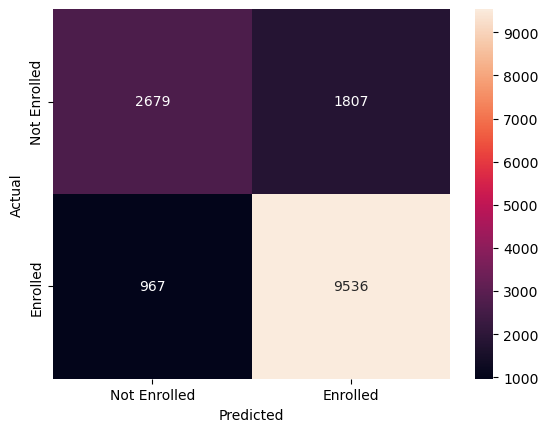

In [34]:
# Evaluation
auc = roc_auc_score(y_test, y_prob_1)
print(f"AUC: {auc:.4f}")
auc_class_0_inverse = roc_auc_score(y_test, y_prob_0)
auc_class_0 = 1 - auc_class_0_inverse
print(f"AUC: {auc_class_0:.4f}")


print('\nClassification Report:')
print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test,y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['Not Enrolled', 'Enrolled']

sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [35]:
import numpy as np
from sklearn.metrics import classification_report

# Test different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
for threshold in thresholds:
    # Classify based on the new threshold
    y_pred_new = np.where(y_prob_0 > threshold, 0, 1)

    # Print the classification report for this threshold
    print(f"--- Threshold: {threshold:.2f} ---")
    print(classification_report(y_test, y_pred_new))

# After reviewing the reports, select the best threshold
best_threshold = 0.18 # example
final_y_pred = np.where(y_prob_0 > best_threshold, 0, 1)

StatementMeta(, 39798f83-437b-4f32-9c41-c258efd1dd9d, 37, Finished, Available, Finished)

--- Threshold: 0.10 ---
              precision    recall  f1-score   support

           0       0.45      0.89      0.60      4486
           1       0.92      0.54      0.68     10503

    accuracy                           0.64     14989
   macro avg       0.68      0.71      0.64     14989
weighted avg       0.78      0.64      0.65     14989

--- Threshold: 0.15 ---
              precision    recall  f1-score   support

           0       0.51      0.84      0.64      4486
           1       0.91      0.65      0.76     10503

    accuracy                           0.71     14989
   macro avg       0.71      0.75      0.70     14989
weighted avg       0.79      0.71      0.72     14989

--- Threshold: 0.20 ---
              precision    recall  f1-score   support

           0       0.56      0.81      0.66      4486
           1       0.90      0.73      0.80     10503

    accuracy                           0.75     14989
   macro avg       0.73      0.77      0.73     14989
we

StatementMeta(, 39798f83-437b-4f32-9c41-c258efd1dd9d, 38, Finished, Available, Finished)

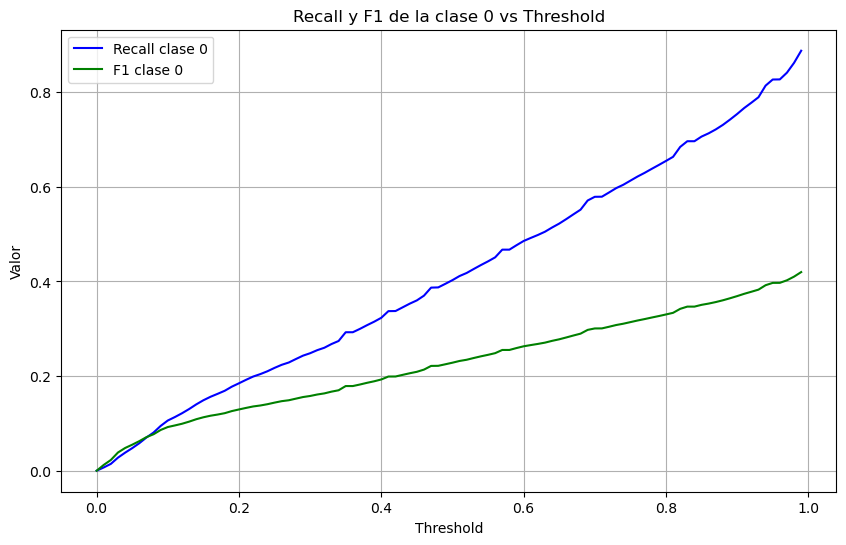

In [36]:
threshold = np.arange(0,1,0.01) # generate the values where the threshold will be evaluated
results = [] # empty list where the results of each threshold will be saved

for t in threshold:
    y_pred = (y_prob_0 >= t).astype(int) # depending on probability under the threshold they will become 0 or 1
    precision, recall, F1, _ = precision_recall_fscore_support(
        y_test, y_pred, average=None, labels= [0,1], zero_division=0
    )
    results.append({
        "threshold": t,
        "presicion_class0": precision[0],
        "recall_class0": recall[0],
        "f1_class0": F1[0]
    })

# converting the list into df 
df_result = pd.DataFrame(results)

# Plot
plt.figure(figsize=(10,6))
plt.plot(df_result["threshold"], df_result["recall_class0"], label="Recall clase 0", color="blue")
plt.plot(df_result["threshold"], df_result["f1_class0"], label="F1 clase 0", color="green")
plt.xlabel("Threshold")
plt.ylabel("Valor")
plt.title("Recall y F1 de la clase 0 vs Threshold")
plt.grid(True)
plt.legend()
plt.show()

StatementMeta(, 39798f83-437b-4f32-9c41-c258efd1dd9d, 40, Finished, Available, Finished)

AUC: 0.7783
AUC: 0.8475
              precision    recall  f1-score   support

           0       0.63      0.74      0.68      4486
           1       0.88      0.82      0.85     10503

    accuracy                           0.79     14989
   macro avg       0.76      0.78      0.76     14989
weighted avg       0.81      0.79      0.80     14989



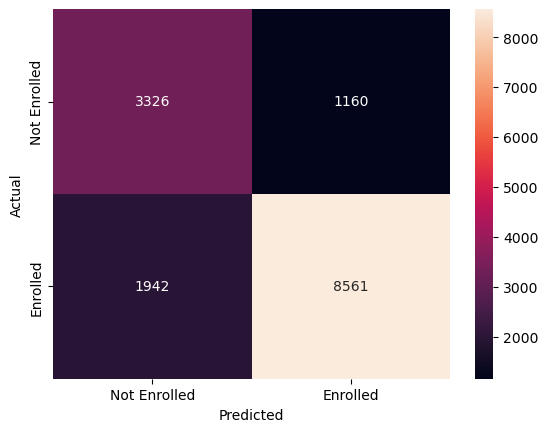

In [38]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 1. Separar datos (asumiendo que X y y ya están definidos)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Entrenar el modelo
modelo = RandomForestClassifier(class_weight='balanced')
modelo.fit(X_train, y_train)

# 3. Obtener las probabilidades de la clase 0 para el conjunto de prueba
y_prob_0 = modelo.predict_proba(X_test)[:, 0]

# 4. Definir tu umbral óptimo (ej. 0.20, basado en el análisis anterior)
best_threshold = 0.3

# 5. Aplicar el umbral para obtener las predicciones finales
y_pred_final = np.where(y_prob_0 > best_threshold, 0, 1)

# Evaluation
auc = roc_auc_score(y_test, y_pred_final)
print(f"AUC_1: {auc:.4f}")
auc_class_0_inverse = roc_auc_score(y_test, y_prob_0)
auc_class_0 = 1 - auc_class_0_inverse
print(f"AUC_0: {auc_class_0:.4f}")

# 6. Evaluar el rendimiento con el nuevo umbral
print(classification_report(y_test, y_pred_final))

cm2 = confusion_matrix(y_test,y_pred_final)

import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['Not Enrolled', 'Enrolled']

sns.heatmap(cm2, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()